In [1]:
#Import neccessary packages
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix,recall_score,precision_score,accuracy_score,f1_score,roc_curve,roc_auc_score,auc,classification_report
from imblearn.over_sampling import SMOTE
from xgboost.sklearn import XGBClassifier


Using TensorFlow backend.


In [2]:
#Read in the train dataset
train_data = pd.read_csv('./train.csv')
train_data.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
UniqueID                               233154 non-null int64
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
branch_id                              233154 non-null int64
supplier_id                            233154 non-null int64
manufacturer_id                        233154 non-null int64
Current_pincode_ID                     233154 non-null int64
Date.of.Birth                          233154 non-null object
Employment.Type                        225493 non-null object
DisbursalDate                          233154 non-null object
State_ID                               233154 non-null int64
Employee_code_ID                       233154 non-null int64
MobileNo_Avl_Flag                      233154 non-null int64
Aadhar_flag                   

In [5]:
train_data['Employment.Type'] = train_data['Employment.Type'].fillna(train_data['Employment.Type'].mode()[0])
train_data.isnull().sum()

UniqueID                               0
disbursed_amount                       0
asset_cost                             0
ltv                                    0
branch_id                              0
supplier_id                            0
manufacturer_id                        0
Current_pincode_ID                     0
Date.of.Birth                          0
Employment.Type                        0
DisbursalDate                          0
State_ID                               0
Employee_code_ID                       0
MobileNo_Avl_Flag                      0
Aadhar_flag                            0
PAN_flag                               0
VoterID_flag                           0
Driving_flag                           0
Passport_flag                          0
PERFORM_CNS.SCORE                      0
PERFORM_CNS.SCORE.DESCRIPTION          0
PRI.NO.OF.ACCTS                        0
PRI.ACTIVE.ACCTS                       0
PRI.OVERDUE.ACCTS                      0
PRI.CURRENT.BALA

In [7]:
#Drop the ID columns
#The manufacturer_id and state_ID might be important categorical features so they should not be dropped
columns_To_drop = ['UniqueID','branch_id','supplier_id','Current_pincode_ID','Employee_code_ID']
train_data = train_data.drop(columns_To_drop,axis =1)


KeyError: "['UniqueID' 'branch_id' 'supplier_id' 'Current_pincode_ID'\n 'Employee_code_ID'] not found in axis"

In [8]:
#Now i will be doin some type conversion.
#Convert all the flag columns to categorical along side the manufacturer id and the state_ID columns               
columns_toCategorical = ['manufacturer_id','State_ID','Passport_flag','Driving_flag','VoterID_flag','PAN_flag',
                      'Aadhar_flag','MobileNo_Avl_Flag']
for col in columns_toCategorical:
    train_data[col] = train_data[col].astype(str)
#convert columns with data tto DateTime
columns_toDate = ['Date.of.Birth','DisbursalDate']
for col in columns_toDate:
    train_data[col] = pd.to_datetime(train_data[col])
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 36 columns):
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
manufacturer_id                        233154 non-null object
Date.of.Birth                          233154 non-null datetime64[ns]
Employment.Type                        233154 non-null object
DisbursalDate                          233154 non-null datetime64[ns]
State_ID                               233154 non-null object
MobileNo_Avl_Flag                      233154 non-null object
Aadhar_flag                            233154 non-null object
PAN_flag                               233154 non-null object
VoterID_flag                           233154 non-null object
Driving_flag                           233154 non-null object
Passport_flag                          233154 non-null object
PERFOR

In [9]:
#Obtain Age as at the age of loanee as at the time of disbursment and drop the birthdate and disbursement date columns
train_data['Age'] = (train_data['DisbursalDate']-train_data['Date.of.Birth'])
train_data['Age_in_years'] = abs(round(train_data['Age']/np.timedelta64(1,'Y')))
train_data['Age_in_years'] = train_data['Age_in_years'].astype(int)




In [10]:
train_data = train_data.drop(['DisbursalDate','Date.of.Birth','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH','Age',
                             'State_ID'],axis =1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 32 columns):
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
manufacturer_id                        233154 non-null object
Employment.Type                        233154 non-null object
MobileNo_Avl_Flag                      233154 non-null object
Aadhar_flag                            233154 non-null object
PAN_flag                               233154 non-null object
VoterID_flag                           233154 non-null object
Driving_flag                           233154 non-null object
Passport_flag                          233154 non-null object
PERFORM_CNS.SCORE                      233154 non-null int64
PERFORM_CNS.SCORE.DESCRIPTION          233154 non-null object
PRI.NO.OF.ACCTS                        233154 non-null int64
PRI.ACTIVE.ACCTS        

In [11]:
correlated_feature = ['SEC.SANCTIONED.AMOUNT','SEC.DISBURSED.AMOUNT','PRI.NO.OF.ACCTS']
train_data = train_data.drop(correlated_feature,axis =1)

In [12]:
#Encode categorical features
final_data = pd.get_dummies(train_data,prefix_sep='_')
# Drop these columns as they are not in the test data
final_data = final_data.drop(['manufacturer_id_156','PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: More than 50 active Accounts found'],axis = 1)
(final_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 62 columns):
disbursed_amount                                                                         233154 non-null int64
asset_cost                                                                               233154 non-null int64
ltv                                                                                      233154 non-null float64
PERFORM_CNS.SCORE                                                                        233154 non-null int64
PRI.ACTIVE.ACCTS                                                                         233154 non-null int64
PRI.OVERDUE.ACCTS                                                                        233154 non-null int64
PRI.CURRENT.BALANCE                                                                      233154 non-null int64
PRI.SANCTIONED.AMOUNT                                                                    233154 non-null int64

In [13]:
Label = final_data['loan_default'] #Extract label column 
trainData = final_data.drop(['loan_default'],axis = 1) #TrainData columns
os = SMOTE(random_state=0) #   We are using SMOTE as the function for oversampling
os_data_train,os_data_test=os.fit_sample(trainData,Label)
os_data_train = pd.DataFrame(data=os_data_train,columns = [col for col in trainData.columns])
os_data_test= pd.DataFrame(data=os_data_test,columns=["loan_default"])

print("length of oversampled data is ",len(os_data_train))
print("Number of 0(non-defaulters) class in oversampled data",len(os_data_test[os_data_test["loan_default"]==0]))
print("Number of 1(defaulters) class in oversampled data",len(os_data_test[os_data_test["loan_default"]==1]))
print("Proportion of 0(non-defaulters) class in oversampled data is ",len(os_data_test[os_data_test["loan_default"]==0])/len(os_data_train))
print("Proportion of 1(defaulters) class in oversampled data is ",len(os_data_test[os_data_test["loan_default"]==1])/len(os_data_train))

x_train, x_test, y_train, y_test = train_test_split(os_data_train,os_data_test,test_size = 0.25, random_state =123)

length of oversampled data is  365086
Number of 0(non-defaulters) class in oversampled data 182543
Number of 1(defaulters) class in oversampled data 182543
Proportion of 0(non-defaulters) class in oversampled data is  0.5
Proportion of 1(defaulters) class in oversampled data is  0.5


In [14]:
num_col = trainData.select_dtypes(include=['Int64','float64','int32'])


In [15]:

# Scale numeric features
scaler = preprocessing.StandardScaler().fit(x_train.loc[:,num_col.columns])
x_train.loc[:,num_col.columns] = scaler.transform(x_train.loc[:,num_col.columns])
x_test.loc[:,num_col.columns] = scaler.transform(x_test.loc[:,num_col.columns])



(x_train.head())


C:\Users\W7\Anaconda2\envs\py3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\W7\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\W7\Anaconda2\envs\py3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value

,disbursed_amount,asset_cost,ltv,PERFORM_CNS.SCORE,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,...,PERFORM_CNS.SCORE.DESCRIPTION_J-High Risk,PERFORM_CNS.SCORE.DESCRIPTION_K-High Risk,PERFORM_CNS.SCORE.DESCRIPTION_L-Very High Risk,PERFORM_CNS.SCORE.DESCRIPTION_M-Very High Risk,PERFORM_CNS.SCORE.DESCRIPTION_No Bureau History Available,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: No Activity seen on the customer (Inactive),PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: No Updates available in last 36 months,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Not Enough Info available on the customer,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Only a Guarantor,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Sufficient History Not Available
42529,-0.449762,-0.425567,-0.184457,-0.839514,-0.546203,-0.320176,-0.173409,-0.073151,-0.072996,-0.094064,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
159701,-1.298583,-0.819464,-0.871133,-0.839514,-0.546203,-0.320176,-0.173409,-0.073151,-0.072996,-0.094064,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
325453,0.978184,0.065041,1.200539,-0.839514,-0.546203,-0.320176,-0.173409,-0.073151,-0.072996,-0.094064,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
178849,0.037816,-0.024197,0.101128,-0.839514,-0.546203,-0.320176,-0.173409,-0.073151,-0.072996,-0.094064,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
87313,0.118022,-0.043358,0.206630,-0.839514,-0.546203,-0.320176,-0.173409,-0.073151,-0.072996,-0.094064,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [20]:
def model_fit(alg, x_train, y_train,x_test,y_test,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train, label=y_train['loan_default'].ravel())
        xgtest  = xgb.DMatrix(x_test,label = y_test['loan_default'].ravel())
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         watchlist = [(xgtrain, 'train'), (xgtest, 'test')]
        alg.set_params(n_estimators=cvresult.shape[0])
        print("Executed 1")
    
    #Fit the algorithm on the data
    alg.fit(x_train,y_train['loan_default'].ravel(),eval_metric='auc',verbose = True)
    print("executed 2")
        
    #Predict training set:
    _predictions = alg.predict(x_test)
#     train_predprob = alg.predict_proba(xgtest)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(y_test['loan_default'].ravel(),_predictions))
    print("AUC Score (Test): %f" % roc_auc_score(y_test['loan_default'].ravel(), _predictions))
    print("Recall Score (Test): %f" % recall_score(y_test['loan_default'].ravel(), _predictions))
    print("Precision Score (Test): %f" % precision_score(y_test['loan_default'].ravel(), _predictions))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [21]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5, 
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 seed=27)
model_fit(xgb1,x_train,y_train,x_test,y_test)

Executed 1
executed 2

Model Report
Accuracy : 0.858
AUC Score (Test): 0.858175
Recall Score (Test): 0.720255
Precision Score (Test): 0.994620


TypeError: 'str' object is not callable

In [24]:
params_ = {
    'subsample': [i/10.0 for i in range(6,9)],
    'colsample_bytree' : [i/10.0 for i in range(6,9)],
    'gamma': [i/10.0 for i in range(0,4)],
    'max_depth': [4,5,6],
    'min_child_weight': [4,5,6]
}
clf_grid = GridSearchCV(estimator = XGBClassifier(
 learning_rate =0.1,
 n_estimators=140,
 max_depth=5, 
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 seed=27),param_grid = params_,scoring = 'roc_auc',cv =3,iid = False,n_jobs = 4,verbose =1
                       )
clf_grid.fit(x_test,y_test)
clf_grid.grid_scores,clf_grid.best_params,clf_grid.best_score_

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 10.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 46.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 113.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 212.3min
[Parallel(n_jobs=4)]: Done 972 out of 972 | elapsed: 308.2min finished
C:\Users\W7\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\W7\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores'

In [27]:
clf_grid.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=140,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8], 'colsample_bytree': [0.6, 0.7, 0.8], 'gamma': [0.0, 0.1, 0.2, 0.3], 'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)>

In [45]:
clf=XGBClassifier(subsample=  0.7,
                  colsample_bytree = 0.6, 
                  gamma =  0.0,
                  max_depth = 6,
                  min_child_weight= 5,
                  learning_rate =0.3,
                  n_estimators=300,
                  objective= 'binary:logistic',
                  scale_pos_weight=1,
                  seed=27
                 )
clf.fit(x_train,y_train['loan_default'].ravel(),eval_metric ='auc',verbose =True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.0, learning_rate=0.3,
       max_delta_step=0, max_depth=6, min_child_weight=5, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.7)

In [46]:
pred = clf.predict(x_test)


confusion matrix 
 [[44960   624]
 [12517 33171]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.78      0.99      0.87     45584
           1       0.98      0.73      0.83     45688

   micro avg       0.86      0.86      0.86     91272
   macro avg       0.88      0.86      0.85     91272
weighted avg       0.88      0.86      0.85     91272



accuracy_score 
 0.8560237531773162
recall_score 
 0.7260330940290667
precision_score 
 0.9815357301375943
f1_score 
 0.8346690487274009


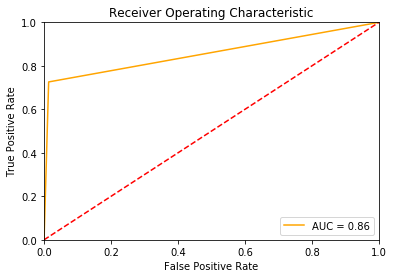

In [47]:
# Evaluate the model performance
print('confusion matrix' ,'\n',confusion_matrix(y_test, pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test,pred))
print('\n')
print('accuracy_score', '\n', accuracy_score(y_test,pred))
print('recall_score', '\n', recall_score(y_test,pred))
print('precision_score', '\n', precision_score(y_test,pred))
print('f1_score', '\n', f1_score(y_test,pred))

# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,pred)
# plotting them against each other

# plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)



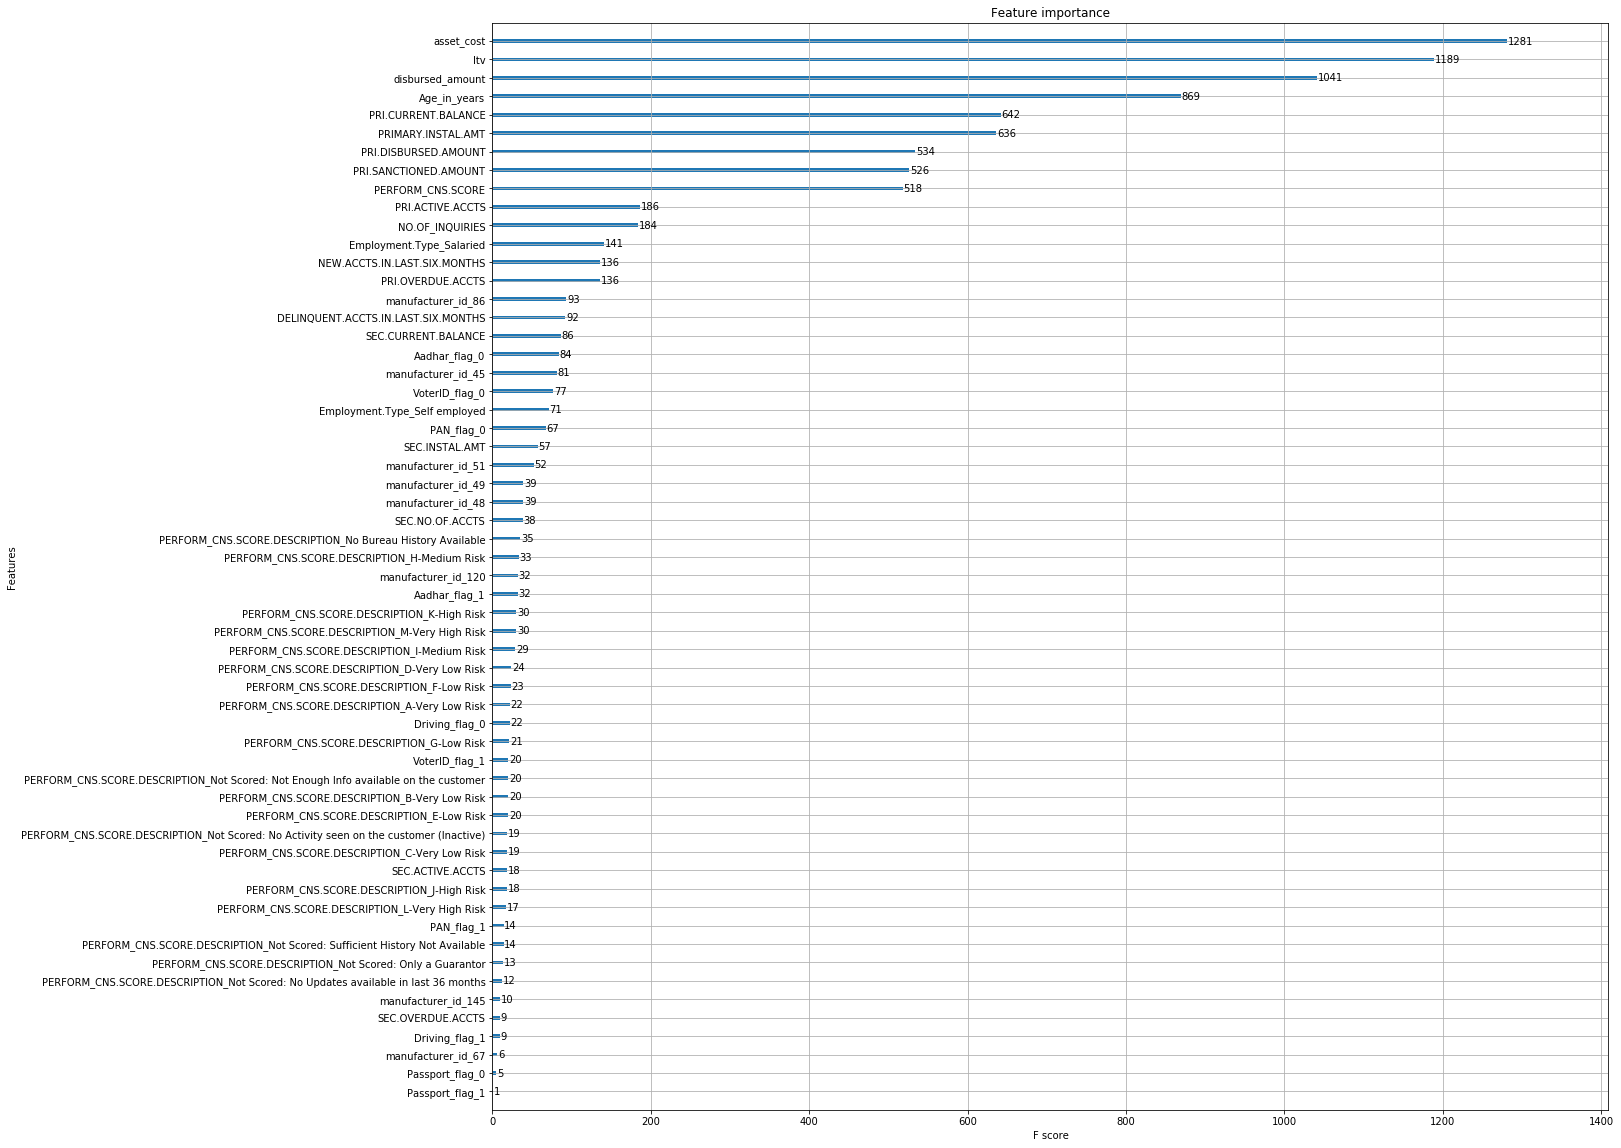

In [55]:
xgb.plot_importance(clf)
plt.rcParams['figure.figsize']  = 30,30
plt.show()

In [51]:
def plot_roc_curve(false_positive_rate, true_positive_rate):
    auc_val = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate,color = 'orange', label = 'AUC = %0.2f' % auc_val)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()    

In [57]:
params = {'objective' : 'binary:logistic','colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="auc", as_pandas=True, seed=123)


[09:03:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[09:03:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[09:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[09:03:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[09:03:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[09:03:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[09:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[09:03:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[09:03:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[09:04:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[09:04:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[09:04:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[09:04:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[09:04:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[09:04:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[09:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[09:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[09:04:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_

[09:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[09:05:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5


In [34]:
cv_results


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.603012,0.000856,0.601066,0.000763
1,0.616527,0.005670,0.614734,0.005186
2,0.622644,0.002405,0.619466,0.003449
3,0.627894,0.001745,0.624623,0.001854
4,0.629338,0.002569,0.625591,0.003089
5,0.631628,0.005223,0.627417,0.005776
6,0.633457,0.004050,0.628709,0.004499
7,0.634618,0.003417,0.630158,0.003713
8,0.636915,0.002209,0.632224,0.002968
9,0.637582,0.001104,0.632990,0.001991


In [24]:
test_data = pd.read_csv('./test.csv')

In [25]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112392 entries, 0 to 112391
Data columns (total 40 columns):
UniqueID                               112392 non-null int64
disbursed_amount                       112392 non-null int64
asset_cost                             112392 non-null int64
ltv                                    112392 non-null float64
branch_id                              112392 non-null int64
supplier_id                            112392 non-null int64
manufacturer_id                        112392 non-null int64
Current_pincode_ID                     112392 non-null int64
Date.of.Birth                          112392 non-null object
Employment.Type                        108949 non-null object
DisbursalDate                          112392 non-null object
State_ID                               112392 non-null int64
Employee_code_ID                       112392 non-null int64
MobileNo_Avl_Flag                      112392 non-null int64
Aadhar_flag                   

In [26]:
#Replace missing values
test_data['Employment.Type'] = test_data['Employment.Type'].fillna(test_data['Employment.Type'].mode()[0])
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112392 entries, 0 to 112391
Data columns (total 40 columns):
UniqueID                               112392 non-null int64
disbursed_amount                       112392 non-null int64
asset_cost                             112392 non-null int64
ltv                                    112392 non-null float64
branch_id                              112392 non-null int64
supplier_id                            112392 non-null int64
manufacturer_id                        112392 non-null int64
Current_pincode_ID                     112392 non-null int64
Date.of.Birth                          112392 non-null object
Employment.Type                        112392 non-null object
DisbursalDate                          112392 non-null object
State_ID                               112392 non-null int64
Employee_code_ID                       112392 non-null int64
MobileNo_Avl_Flag                      112392 non-null int64
Aadhar_flag                   

In [27]:
#Drop columns
test_data = test_data.drop(columns_To_drop,axis =1)
#Convert columns
for col in columns_toCategorical:
    test_data[col] = test_data[col].astype(str)
#convert columns with data tto DateTime
columns_toDate = ['Date.of.Birth','DisbursalDate']
for col in columns_toDate:
    test_data[col] = pd.to_datetime(test_data[col])
#Obtain age
test_data['Age'] = (test_data['DisbursalDate']-test_data['Date.of.Birth'])
test_data['Age_in_years'] = abs(round(test_data['Age']/np.timedelta64(1,'Y')))
test_data['Age_in_years'] = test_data['Age_in_years'].astype(int)
#Drop colum
test_data = test_data.drop(['DisbursalDate','Date.of.Birth','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH','Age','State_ID'],axis =1)
#Drop correlated features
test_data = test_data.drop(correlated_feature,axis =1)
#Encode categorical features
test_data = pd.get_dummies(test_data,prefix_sep='_')

test_data.loc[:,num_col.columns] = scaler.transform(test_data.loc[:,num_col.columns])
new_test = pd.DataFrame(data = test_data )
new_test.shape









C:\Users\W7\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.


(112392, 62)

In [28]:
new_test = pd.DataFrame(data = test_data )
new_test = new_test.drop(['manufacturer_id_155'],axis =1)
new_test.head()


,disbursed_amount,asset_cost,ltv,PERFORM_CNS.SCORE,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,...,PERFORM_CNS.SCORE.DESCRIPTION_J-High Risk,PERFORM_CNS.SCORE.DESCRIPTION_K-High Risk,PERFORM_CNS.SCORE.DESCRIPTION_L-Very High Risk,PERFORM_CNS.SCORE.DESCRIPTION_M-Very High Risk,PERFORM_CNS.SCORE.DESCRIPTION_No Bureau History Available,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: No Activity seen on the customer (Inactive),PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: No Updates available in last 36 months,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Not Enough Info available on the customer,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Only a Guarantor,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Sufficient History Not Available
0,-0.122517,-0.662653,0.998809,-0.839514,-0.546203,-0.320176,-0.173409,-0.073151,-0.072996,-0.094064,...,0,0,0,0,1,0,0,0,0,0
1,0.038767,-0.683735,1.263475,1.450458,0.009446,-0.320176,-0.121741,-0.055142,-0.055001,-0.094064,...,0,0,0,0,0,0,0,0,0,0
2,0.813009,0.445491,0.397626,-0.839514,-0.546203,-0.320176,-0.173409,-0.073151,-0.072996,-0.094064,...,0,0,0,0,1,0,0,0,0,0
3,-0.643461,-0.644612,0.092942,-0.796711,0.009446,1.558781,-0.017480,0.020993,0.021077,-0.094064,...,0,0,0,0,0,0,0,0,1,0
4,-0.284990,-0.644612,0.956972,-0.839514,-0.546203,-0.320176,-0.173409,-0.073151,-0.072996,-0.094064,...,0,0,0,0,1,0,0,0,0,0


In [48]:
predictions = clf.predict(new_test)
v=pd.DataFrame(predictions)
v.head(12)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [49]:
test_Copy = pd.read_csv('./test.csv')
UniqueID = test_Copy['UniqueID']
submission = pd.DataFrame({'UniqueID' : UniqueID,
                            'loan_default' : predictions})
submission.to_csv('./ltfs2.csv', index=False)
sub = pd.read_csv('./ltfs2.csv')
sub.groupby('loan_default')['UniqueID'].count()

loan_default
0    110360
1      2032
Name: UniqueID, dtype: int64